# Example prediction on a single test image



In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import cv2

from monodepth2.layers import *
from monodepth2 import networks
from monodepth2.utils import download_model_if_doesnt_exist


In [2]:
def cv2_clipped_zoom(img, zoom_factor):

    height, width = img.shape[:2]
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)


    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])

    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]


    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LANCZOS4)
    return result

In [3]:
image_path  = "images/test_image.jpg"
angle = -10
rot_image_path = "images/test_image"+str(angle)+".jpg"

image = cv2.imread(image_path)
rot_and_resized = cv2_clipped_zoom(rotate_image(image, angle), 1.75)
cv2.imwrite(rot_image_path, rot_and_resized)


True

In [4]:
input_image = pil.open(rot_image_path).convert('RGB')
disp_list = [] 
vmax_list = []
models_t = next(os.walk('models'))[1]
models = ['models/'+s for s in models_t]

for model_name in models:

    encoder_path = os.path.join(model_name, "encoder.pth")
    depth_decoder_path = os.path.join(model_name, "depth.pth")

    # LOADING PRETRAINED MODEL
    encoder = networks.ResnetEncoder(18, False)
    depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
    loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)
    loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
    depth_decoder.load_state_dict(loaded_dict)
    encoder.eval()
    depth_decoder.eval();

    original_width, original_height = input_image.size
    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)


    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)
    disp = outputs[("disp", 0)]

    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)
    
    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)
    disp_list.append(disp_resized_np)
    vmax_list.append(vmax)

In [5]:
models

['models/mono+stereo_640x192_no roll',
 'models/mono_1024x320 - original',
 'models/mono_640x192 - original',
 'models/mono_640x192_no roll',
 'models/mono_640x192_roll']

IndexError: list index out of range

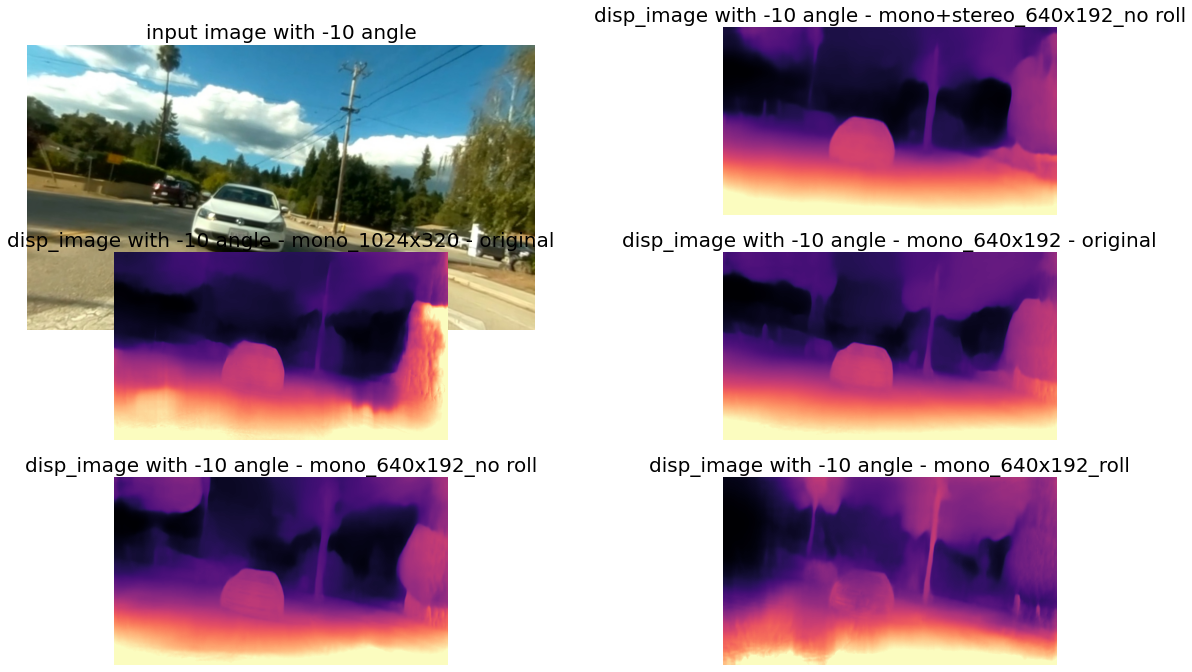

In [6]:
fig=plt.figure(figsize=(20, 20))
fig.tight_layout()
columns = 2
rows = 5
ax = fig.add_subplot(321)
ax.set_title('input image with '+str(angle)+' angle', fontsize=20)
plt.imshow(input_image, cmap='magma')
plt.axis('off')
for i in range(2, columns*rows+1):
    img = disp_list[i-2]
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title('disp_image with '+str(angle)+' angle - '+models_t[i-2], fontsize=20)
    plt.imshow(img, cmap='magma', vmax=vmax_list[i-2])
    plt.axis('off')
    
plt.savefig('images/out_image_angle_'+str(angle)+'.jpg')
plt.show()